In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.losses import MeanAbsoluteError as MAE
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, Callback

log_path = "text_file_name.txt" # it will be created automatically

class TrainLogger(Callback, ):
    
    def __init__(self, n):
        self.n = n
        
    def on_epoch_end(self, epoch, logs=None):
        if(int(epoch) % self.n) == 0:
          print("> Epoch: {:>5} | Loss: ".format(epoch) + f"{logs['loss']:.5}" + " | Valid loss: " + f"{logs['val_loss']:.5}")



In [2]:
df = pd.read_csv("../data/cup/cup.train", comment="#", index_col='id', skipinitialspace=True)
df

a1        a2        a3        a4        a5        a6        a7  \
id                                                                           
1    -1.704815  1.503106 -0.817083  1.353560 -1.293660  1.362608  0.217795   
2    -0.888962  0.711473 -0.480023  0.748175 -0.981763  1.765482 -0.445018   
3     1.143802 -1.591273  0.670477 -0.948551  1.075740 -0.908309 -0.694223   
4     0.630938 -0.295533  1.379162 -0.041045 -0.250695  0.025003  0.143915   
5     1.799449 -0.913254  1.245698 -1.410940  0.653328 -0.677108 -0.667490   
...        ...       ...       ...       ...       ...       ...       ...   
1488 -0.055410 -0.389189  1.266899  1.185345  0.067729  0.549779  1.254178   
1489  1.589704 -1.900020  0.415666 -1.010273  1.494894 -1.407505 -1.226479   
1490  0.222560  0.171394  2.338296  0.215360  0.297860  0.131239  0.619090   
1491  1.484195 -1.616400 -0.308850 -0.448055  0.903576 -0.823968 -0.213782   
1492 -1.701126  0.883360 -0.332723 -0.762716 -1.275077  1.226050  0.032551   

            a8        a9         tx         ty  
id                                              
1     0.462728 -1.237246  22.222923 -27.036774  
2     1.719143 -1.096250  18.885520 -28.377440  
3    -1.321391  0.662656   4.587627 -18.507566  
4     0.861455  0.879540  10.256820 -30.017064  
5    -0.849795  0.497977   4.916182 -17.670030  
...        ...       ...        ...        ...  
1488 -1.132311  0.798819  10.654978 -31.277454  
1489 -1.350128 -0.010998   4.982587 -16.444900  
1490  0.448008  0.134578  10.887319 -30.498420  
1491 -1.155141  0.681062   4.286232 -23.027878  
1492  0.518337 -1.395780  18.453878 -28.434854  

[1492 rows x 11 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1492 entries, 1 to 1492
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a1      1492 non-null   float64
 1   a2      1492 non-null   float64
 2   a3      1492 non-null   float64
 3   a4      1492 non-null   float64
 4   a5      1492 non-null   float64
 5   a6      1492 non-null   float64
 6   a7      1492 non-null   float64
 7   a8      1492 non-null   float64
 8   a9      1492 non-null   float64
 9   tx      1492 non-null   float64
 10  ty      1492 non-null   float64
dtypes: float64(11)
memory usage: 139.9 KB


First try to plot correlation matrix, we see that tx is high correlated with even numbers and negative correlated with odd ones. Ty has not strong correlation with anything but A8-A6.

<AxesSubplot: >

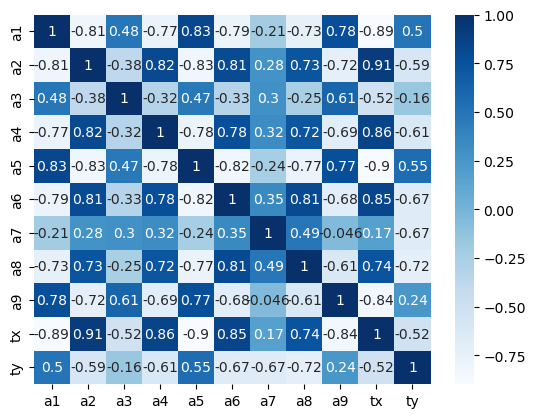

In [4]:
sns.heatmap(df.corr(), annot=True, cmap='Blues')

<AxesSubplot: xlabel='tx', ylabel='ty'>

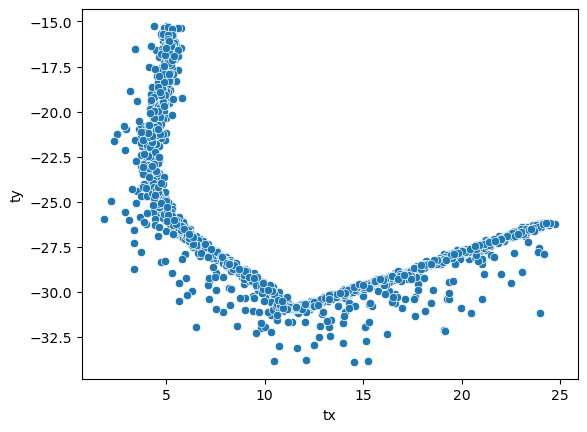

In [5]:
sns.scatterplot(x=df['tx'], y=df['ty'])

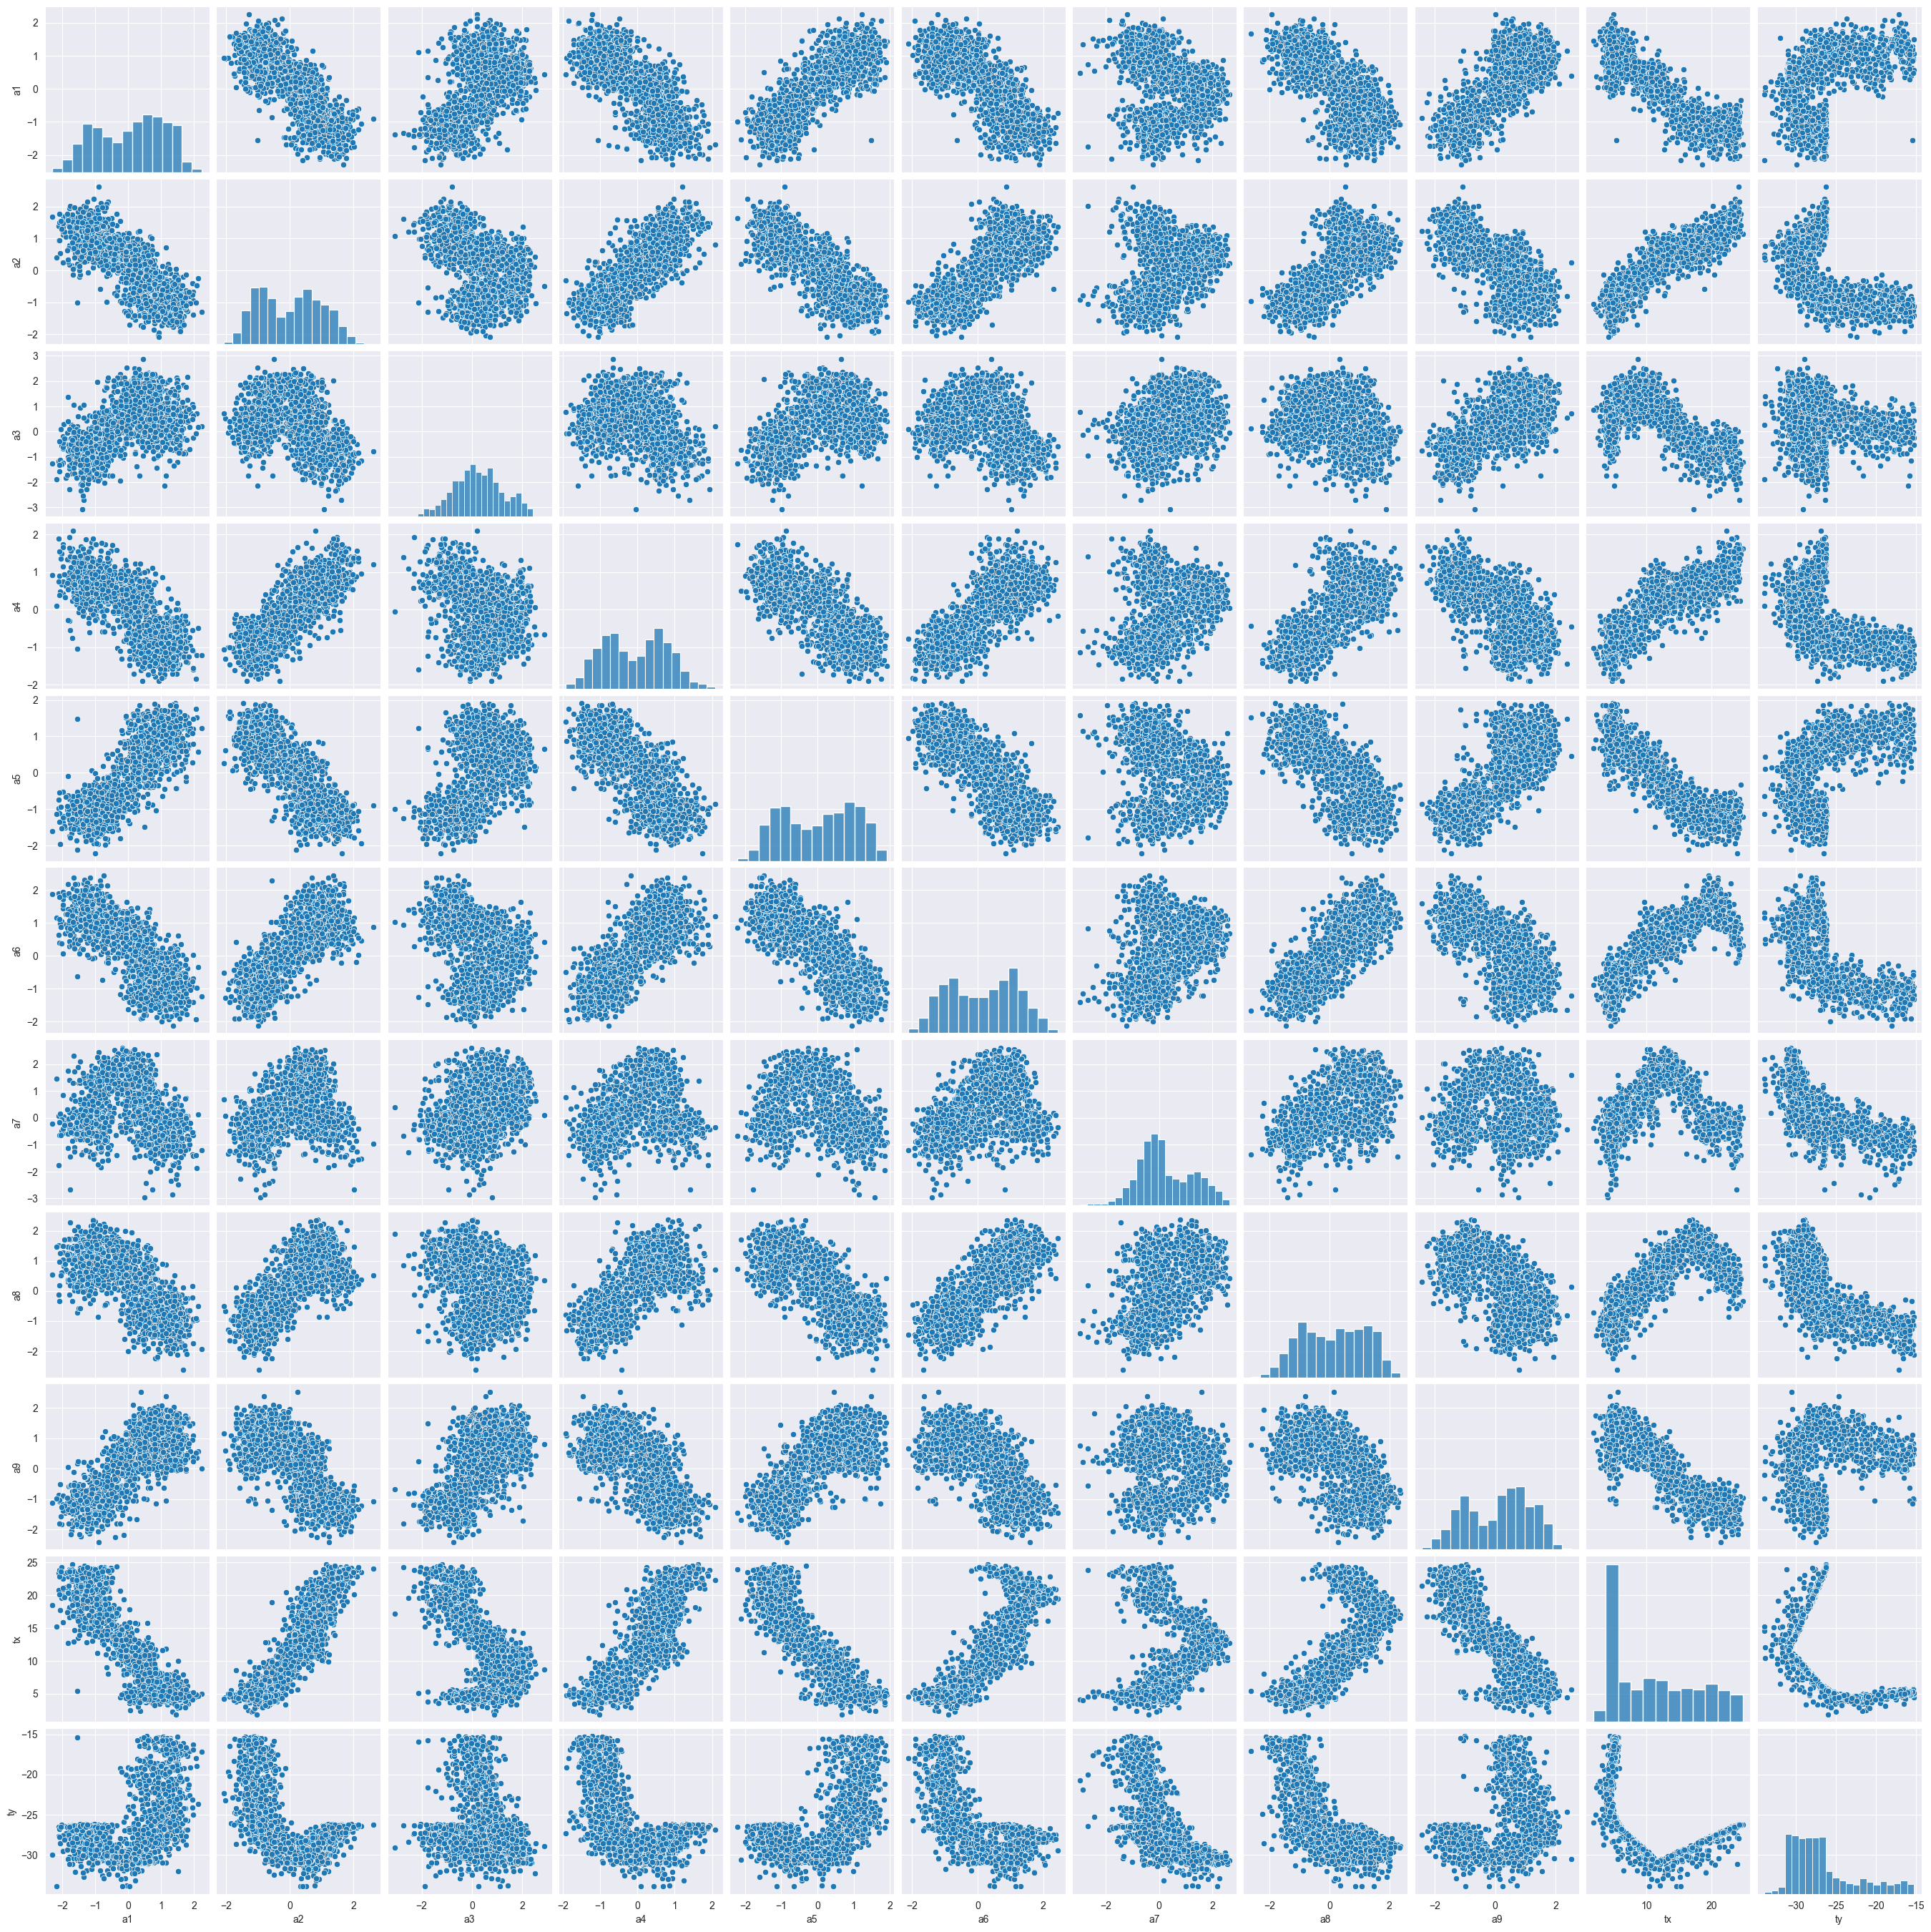

In [28]:
sns.pairplot(df)

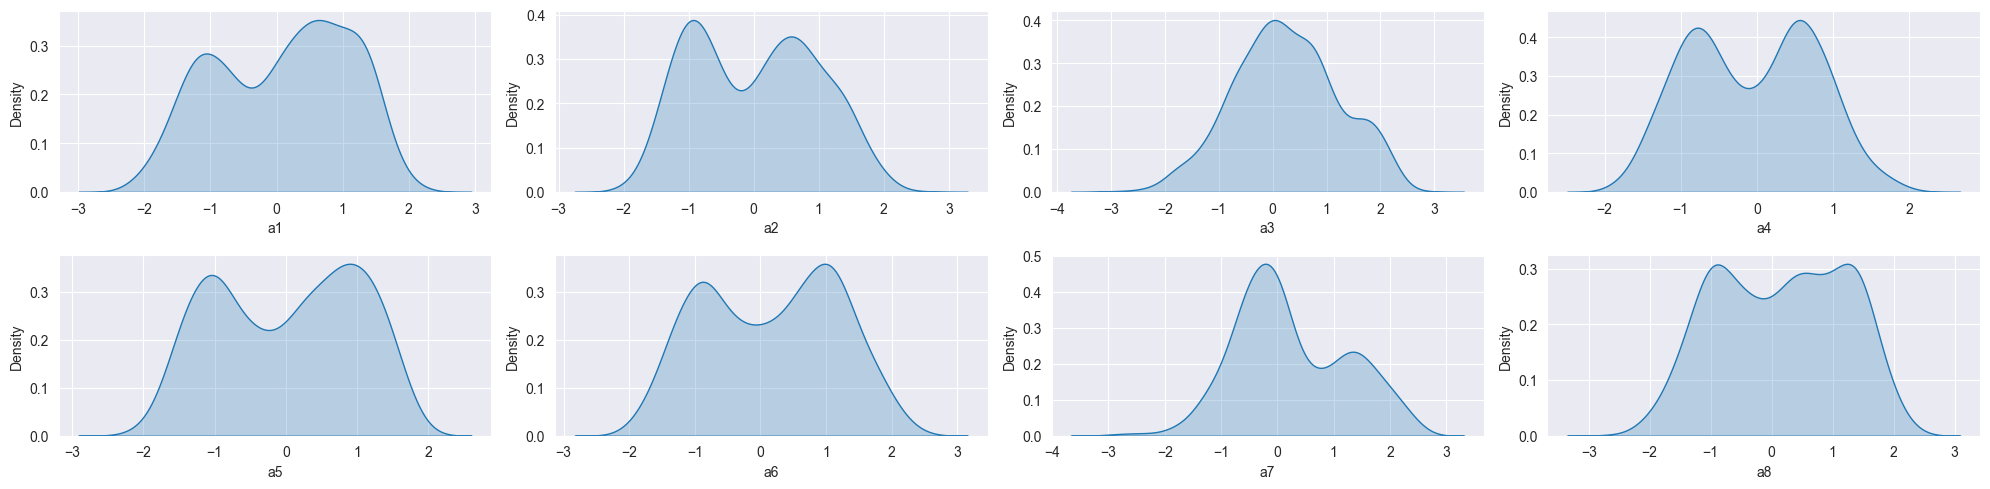

In [57]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, axs = plt.subplots(2, 4)

sns.kdeplot(df["a1"], fill=True, ax=axs[0][0])
sns.kdeplot(df["a2"], fill=True, ax=axs[0][1])
sns.kdeplot(df["a3"], fill=True, ax=axs[0][2])
sns.kdeplot(df["a4"], fill=True, ax=axs[0][3])

sns.kdeplot(df["a5"], fill=True, ax=axs[1][0])
sns.kdeplot(df["a6"], fill=True, ax=axs[1][1])
sns.kdeplot(df["a7"], fill=True, ax=axs[1][2])
sns.kdeplot(df["a8"], fill=True, ax=axs[1][3])

plt.tight_layout()

<AxesSubplot: xlabel='ty', ylabel='Density'>

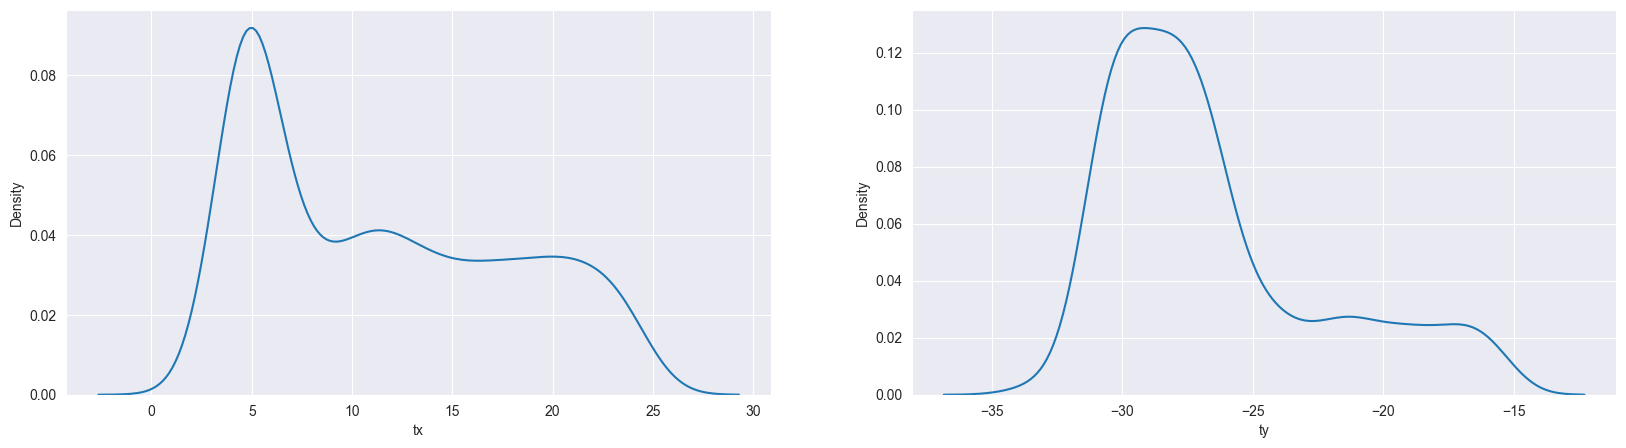

In [58]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, axs = plt.subplots(1, 2)
sns.kdeplot(df['tx'], ax=axs[0])
sns.kdeplot(df['ty'], ax=axs[1])

In [6]:
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
scaled

a1        a2        a3        a4        a5        a6        a7  \
0     0.129584  0.762457  0.378329  0.815240  0.223567  0.763008  0.570487   
1     0.309430  0.594018  0.435119  0.664070  0.299151  0.851400  0.452019   
2     0.757529  0.104053  0.628962  0.240382  0.797755  0.264758  0.407477   
3     0.644474  0.379753  0.748365  0.466995  0.476314  0.469531  0.557282   
4     0.902059  0.248318  0.725878  0.124919  0.695390  0.315485  0.412256   
...        ...       ...       ...       ...       ...       ...       ...   
1487  0.493177  0.359826  0.729450  0.773236  0.553479  0.584669  0.755725   
1488  0.855823  0.038360  0.586030  0.224970  0.899330  0.155232  0.312345   
1489  0.554452  0.479103  0.909966  0.531021  0.609248  0.492840  0.642212   
1490  0.832565  0.098707  0.463959  0.365361  0.756033  0.283263  0.493349   
1491  0.130398  0.630591  0.459937  0.286787  0.228071  0.733046  0.537377   

            a8        a9        tx        ty  
0     0.618781  0.239102  0.889212  0.367689  
1     0.870710  0.267611  0.743371  0.295785  
2     0.261039  0.623261  0.118569  0.825130  
3     0.698732  0.667114  0.366306  0.207848  
4     0.355601  0.589963  0.132926  0.870049  
...        ...       ...       ...       ...  
1487  0.298953  0.650793  0.383705  0.140251  
1488  0.255277  0.487048  0.135828  0.935756  
1489  0.615829  0.516484  0.393858  0.182032  
1490  0.294375  0.626982  0.105398  0.582695  
1491  0.629931  0.207046  0.724509  0.292706  

[1492 rows x 11 columns]

In [31]:
x_train, x_val, y_train, y_val = train_test_split(scaled.drop(["ty", 'tx'], axis=1).values, scaled[['tx','ty']].values, test_size=0.25, random_state=42)
x_train.shape, y_train.shape

((1119, 9), (1119, 2))

In [40]:
model = Sequential([
    Dense(8, 'relu', input_shape=(9,)),
    Dense(8, 'relu'),
    Dense(2, 'sigmoid')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8)                 80        
                                                                 
 dense_13 (Dense)            (None, 8)                 72        
                                                                 
 dense_14 (Dense)            (None, 2)                 18        
                                                                 
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(
    optimizer=SGD(learning_rate=10e-3, momentum=0, nesterov=False),
    metrics=[MeanSquaredError()],
    loss=MAE()
)

In [42]:
history = model.fit(
    x=x_train, 
    y=y_train, 
    validation_data=(x_val, y_val), 
    verbose=0, 
    callbacks=EarlyStopping(patience=50, restore_best_weights=True, monitor='val_loss'),
    epochs=2000
)

history = pd.DataFrame(history.history)

In [43]:
history.tail()

loss  mean_squared_error  val_loss  val_mean_squared_error
1995  0.046870            0.004908  0.049390                0.005422
1996  0.046898            0.004911  0.049377                0.005417
1997  0.046863            0.004904  0.049448                0.005424
1998  0.046884            0.004911  0.049409                0.005423
1999  0.046926            0.004918  0.049346                0.005410

<AxesSubplot: >

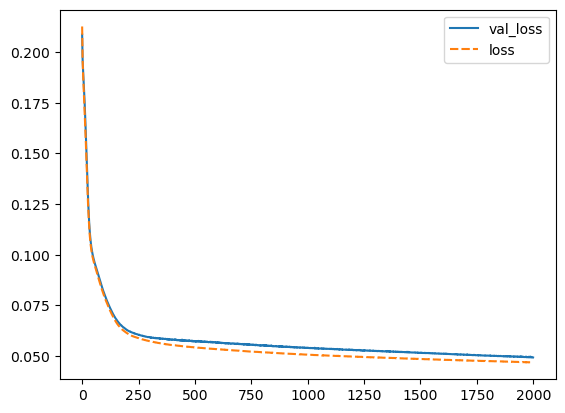

In [ ]:
sns.lineplot(history[['val_loss','loss']])

In [66]:
model = Sequential([
    Dense(16, 'relu', input_shape=(9,)),
    Dense(8, 'relu'),
    Dense(2, 'sigmoid')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 16)                160       
                                                                 
 dense_22 (Dense)            (None, 8)                 136       
                                                                 
 dense_23 (Dense)            (None, 2)                 18        
                                                                 
Total params: 314
Trainable params: 314
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.compile(
    optimizer=SGD(learning_rate=10e-3, momentum=0.5, nesterov=True),
    metrics=[MeanSquaredError()],
    loss=MAE()
)

In [68]:
history = model.fit(
    x=x_train, 
    y=y_train, 
    validation_data=(x_val, y_val), 
    callbacks=[EarlyStopping(patience=100, restore_best_weights=True, monitor='val_loss'), TrainLogger(100)],
    epochs=5000,
    verbose=0
)

history = pd.DataFrame(history.history)

Epoch:     0 | Loss: 0.25849 | Valid loss: 0.23986
Epoch:   100 | Loss: 0.067993 | Valid loss: 0.066935
Epoch:   200 | Loss: 0.059635 | Valid loss: 0.059619
Epoch:   300 | Loss: 0.055842 | Valid loss: 0.056621
Epoch:   400 | Loss: 0.053545 | Valid loss: 0.054609
Epoch:   500 | Loss: 0.052099 | Valid loss: 0.054055
Epoch:   600 | Loss: 0.051115 | Valid loss: 0.052951
Epoch:   700 | Loss: 0.050426 | Valid loss: 0.052396
Epoch:   800 | Loss: 0.049903 | Valid loss: 0.051909
Epoch:   900 | Loss: 0.049484 | Valid loss: 0.051127
Epoch:  1000 | Loss: 0.049106 | Valid loss: 0.050684
Epoch:  1100 | Loss: 0.048815 | Valid loss: 0.050448
Epoch:  1200 | Loss: 0.048512 | Valid loss: 0.049987
Epoch:  1300 | Loss: 0.048232 | Valid loss: 0.049609
Epoch:  1400 | Loss: 0.048036 | Valid loss: 0.049612
Epoch:  1500 | Loss: 0.047925 | Valid loss: 0.049322
Epoch:  1600 | Loss: 0.047734 | Valid loss: 0.049167
Epoch:  1700 | Loss: 0.047564 | Valid loss: 0.049137
Epoch:  1800 | Loss: 0.047511 | Valid loss: 0.04

In [71]:
history.tail()

loss  mean_squared_error  val_loss  val_mean_squared_error
4991  0.045458            0.004755  0.046830                0.005037
4992  0.045376            0.004744  0.046771                0.005016
4993  0.045434            0.004757  0.046776                0.005007
4994  0.045468            0.004765  0.046963                0.005027
4995  0.045359            0.004736  0.046807                0.005014

<AxesSubplot: >

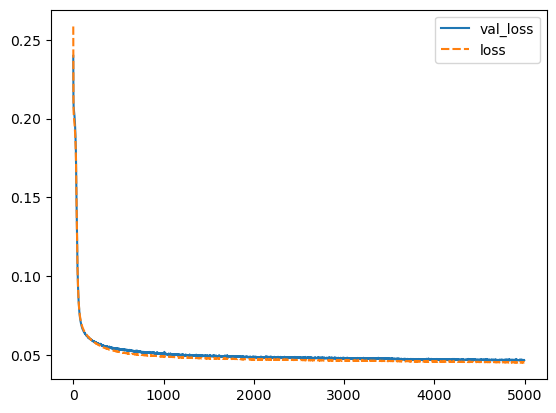

In [72]:
sns.lineplot(history[['val_loss','loss']])
sns.lineplot(history[['val_loss','loss']])

In [87]:
load_cup()[3][0].shape

(2, 1)